<b>Group Members:</b>

1.Nihar Shah

2.Jayshri Gupta

3.Pravesh Raikwar

4.Shardul Naik

5.Keshav Baheti

<b>Problem Statement:</b> Prediction of house prices based on the median aggregate prices present in the dataset quarterly. 

<b>Scope of Study:</b> We started with the raw data and then took the data for Median Aggregate for quarters. We, then, limited the scope of our study to the comparison of time-series models to prices of <i>"houses with rooms 2."</i>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [ ]:
df=pd.read_csv('raw_sales.csv')
df_median = pd.read_csv('ma_lga_12345.csv')
#The data in ma_lga_12345.csv or df_median has been resampled to quartely intervals with a median aggregator

## The file ma_lga_12345.csv has the median aggregated data created from the raw data. 

#### Raw data consists of following columns:

1. datesold: The date on which the property was sold.
2. postcode: The area where property is located.
3. price: The price of the property.
4. propertyType: House/unit
5. bedrooms: No. of bedrooms in the property.

#### The raw data has been processed to convert raw data into time series acceptable data by the following steps:

1. The data is divided into two parts according to propertyType.
2. Each part is then segregated according to the number of bedrooms.
3. Median is then taken for each category quarterly.
4. Date has been assigned to each row as 'saledate' of the last day belonging to the respective quarter.

#### Columns in ma_lga_12345.csv are:
1. saledate: The last day of the quarter
2. MA: The median aggregated price for the quarter
3. type : House/unit
4. bedrooms: 2,3,4,5

In [ ]:
df.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


(-1.1062735784564333,
 1.1060571843127553,
 -1.1058990226661722,
 1.1039583716883157)

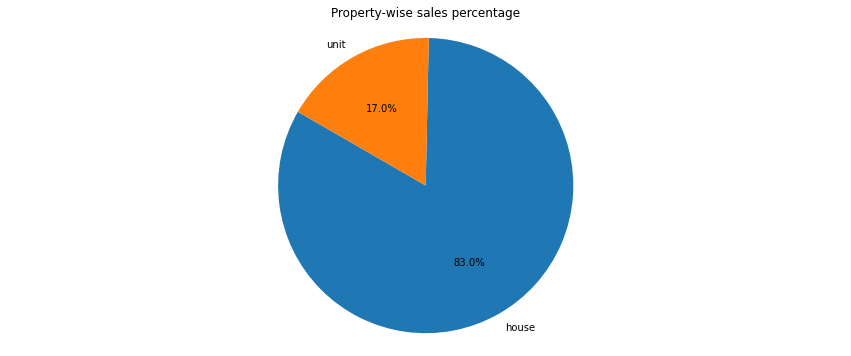

In [ ]:
plt.pie(df['propertyType'].value_counts(), labels=['house','unit'], autopct='%1.1f%%', startangle = 150)
plt.title('Property-wise sales percentage')
plt.axis('equal')

In [ ]:
#Limiting dataset to houses only
df=df[df.propertyType=='house'] 

In [ ]:
print("Time period from {} to {}".format(df.datesold.min(), df.datesold.max()))

Time period from 2007-02-07 00:00:00 to 2019-07-27 00:00:00


In [ ]:
#Removing the timestamp
df['datesold'] = pd.to_datetime(df['datesold'])

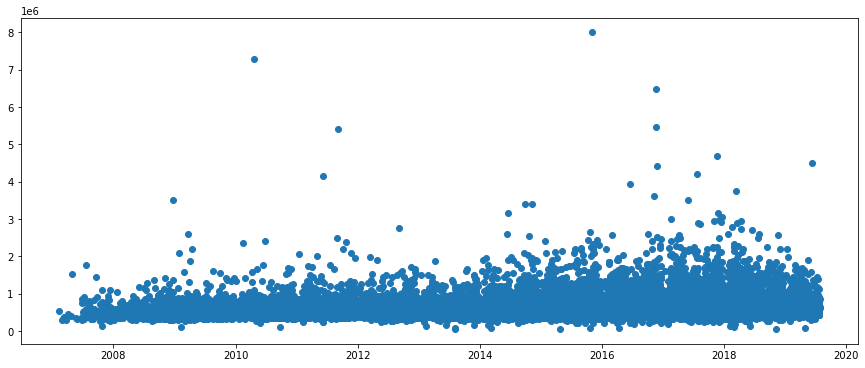

In [ ]:
plt.plot_date(df['datesold'],df['price'])

We find some extreme prices around the year 2016(outliers, we take 5*std deviation to treat them, 
the prices also show a growing trend since the beginning of our dataset.

In [ ]:
# Cleaning the outliers
df = df[np.abs(df.price - df.price.mean()) <= (5.0 * df.price.std())]

In [ ]:
#Viewing and working on the dataset with medians aggregated

In [ ]:
df_median.head()

,saledate,MA,type,bedrooms
0,30/09/2007,441854,house,2
1,31/12/2007,441854,house,2
2,31/03/2008,441854,house,2
3,30/06/2008,441854,house,2
4,30/09/2008,451583,house,2


In [ ]:
df_median=df_median[df_median.type=='house'] #We just need houses only
df_median['saledate'] = pd.to_datetime(df_median['saledate']) #Getting the saledate column to datetime type
df_median.tail()

,saledate,MA,type,bedrooms
195,2018-09-30,1007114,house,5
196,2018-12-31,1002323,house,5
197,2019-03-31,998136,house,5
198,2019-06-30,995363,house,5
199,2019-09-30,970268,house,5


In [ ]:
df_median.drop(columns=['type'],axis=1)

,saledate,MA,bedrooms
0,2007-09-30,441854,2
1,2007-12-31,441854,2
2,2008-03-31,441854,2
3,2008-06-30,441854,2
4,2008-09-30,451583,2
...,...,...,...
195,2018-09-30,1007114,5
196,2018-12-31,1002323,5
197,2019-03-31,998136,5
198,2019-06-30,995363,5


## Pivoting the data based on number of bedrooms to analyse the prices for each type seperately.


In [ ]:
#Getting data ready for the model building
df_median=df_median.pivot(index='saledate', columns='bedrooms', values='MA').interpolate(method='linear', limit_direction='both')
df_median.head()

bedrooms,2,3,4,5
saledate,,,,
2007-03-31,441854.0,421291.0,548969.0,735904.0
2007-06-30,441854.0,421291.0,548969.0,735904.0
2007-09-30,441854.0,421291.0,548969.0,735904.0
2007-12-31,441854.0,421291.0,548969.0,735904.0
2008-03-31,441854.0,416031.0,552484.0,735904.0


<AxesSubplot:xlabel='saledate'>

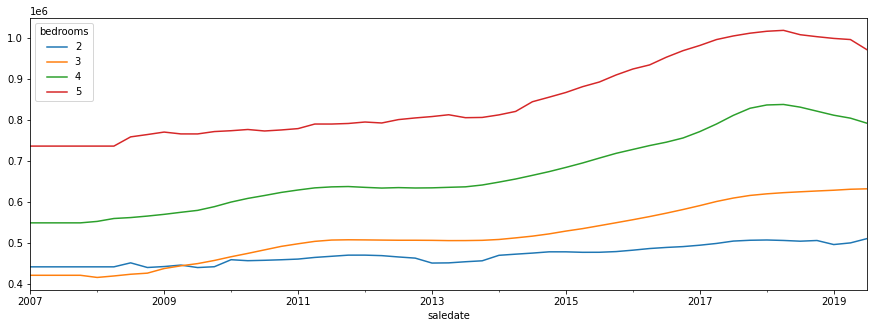

In [ ]:
df_median.plot(figsize=(15,5))

There is a problem with the data between 2007 and 2009 as ideally the price of 2bhk houses should be lower than those of 3bhk; however we shall leave it at this point.

In [ ]:
#Converting the data into monthly samples
df_monthly = df_median.resample('M').interpolate(method='linear', limit_direction='both').astype(int)

In [ ]:
df_monthly.head()

bedrooms,2,3,4,5
saledate,,,,
2007-03-31,441854,421291,548969,735904
2007-04-30,441854,421291,548969,735904
2007-05-31,441854,421291,548969,735904
2007-06-30,441854,421291,548969,735904
2007-07-31,441854,421291,548969,735904


In [ ]:
#Split the data into train and test
train = df_median[:int(0.9*(len(df_median)))]
test = df_median[int(0.9*(len(df_median))):]

#Fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train, freq='Q-DEC')
model_fit = model.fit()

#Forecast based on train data
forecast = model_fit.forecast(model_fit.endog, steps=len(test))

In [ ]:
train

bedrooms,2,3,4,5
saledate,,,,
2007-03-31,441854.0,421291.0,548969.0,735904.0
2007-06-30,441854.0,421291.0,548969.0,735904.0
2007-09-30,441854.0,421291.0,548969.0,735904.0
2007-12-31,441854.0,421291.0,548969.0,735904.0
2008-03-31,441854.0,416031.0,552484.0,735904.0
2008-06-30,441854.0,419628.0,559580.0,735904.0
2008-09-30,451583.0,423811.0,561852.0,758340.0
2008-12-31,440256.0,426488.0,565467.0,764025.0
2009-03-31,442566.0,437724.0,569682.0,770046.0


In [ ]:
test

bedrooms,2,3,4,5
saledate,,,,
2018-06-30,506116.0,622466.0,837295.0,1017752.0
2018-09-30,504318.0,624602.0,830727.0,1007114.0
2018-12-31,506001.0,626608.0,820924.0,1002323.0
2019-03-31,496133.0,628423.0,811121.0,998136.0
2019-06-30,500158.0,630814.0,803925.0,995363.0
2019-09-30,510712.0,631875.0,791446.0,970268.0


In [ ]:
cols = df_median.columns
pred = pd.DataFrame(index=test.index, data=forecast,columns=[cols])
pred=pred.astype(int)
pred.head()

bedrooms,2,3,4,5
saledate,,,,
2018-06-30,516161,629493,853001,1032241
2018-09-30,523161,639565,870641,1051271
2018-12-31,529220,650081,889273,1072171
2019-03-31,534918,661189,909100,1094730
2019-06-30,540601,672991,930274,1118879


<AxesSubplot:xlabel='saledate'>

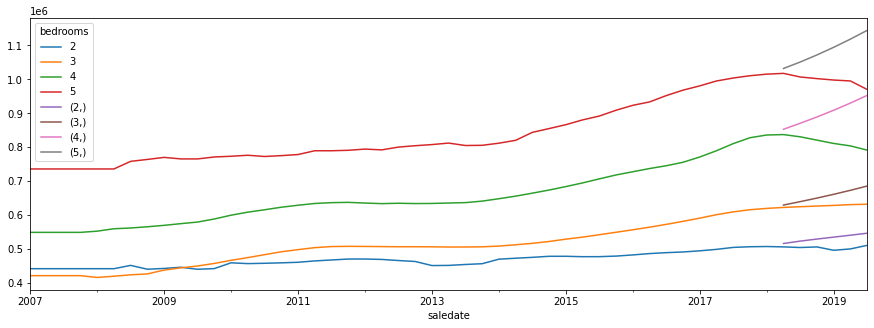

In [ ]:
#Plot actuals (df) and forecast (pred) on the same chart
ax = df_median.plot()
pred.plot(ax=ax,figsize=(15,5))

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
MAE_VAR = mean_absolute_error(y_true=test.iloc[:,0],y_pred=pred.iloc[:4,0])
MAE_VAR

22614.0

In [ ]:
df_median.head()

bedrooms,2,3,4,5
saledate,,,,
2007-03-31,441854.0,421291.0,548969.0,735904.0
2007-06-30,441854.0,421291.0,548969.0,735904.0
2007-09-30,441854.0,421291.0,548969.0,735904.0
2007-12-31,441854.0,421291.0,548969.0,735904.0
2008-03-31,441854.0,416031.0,552484.0,735904.0


In [ ]:
df2= pd.read_csv('ma_lga_12345.csv')

In [ ]:
df2.head()

,saledate,MA,type,bedrooms
0,30/09/2007,441854,house,2
1,31/12/2007,441854,house,2
2,31/03/2008,441854,house,2
3,30/06/2008,441854,house,2
4,30/09/2008,451583,house,2


In [ ]:
df2=df2[df2.type=='house']
df2.drop(columns=['type'],axis=1,inplace=True)

In [ ]:
data1=df2[df2.bedrooms==2]

In [ ]:
data1.head()

,saledate,MA,bedrooms
0,30/09/2007,441854,2
1,31/12/2007,441854,2
2,31/03/2008,441854,2
3,30/06/2008,441854,2
4,30/09/2008,451583,2


In [ ]:
data1.drop(columns=['bedrooms'],axis=1,inplace=True)

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
data1.reset_index(inplace=True)

In [ ]:
for i in range(len(data1.saledate)):
    data1.saledate.loc[i] = datetime.strftime(datetime.strptime(data1.saledate.loc[i], '%d/%m/%Y'), '%m-%Y')

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-39-8b4562ce3116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.saledate.loc[i] = datetime.strftime(datetime.strptime(data1.saledate.loc[i], '%d/%m/%Y'), '%m-%Y')


In [ ]:
data1

,index,saledate,MA
0,0,09-2007,441854
1,1,12-2007,441854
2,2,03-2008,441854
3,3,06-2008,441854
4,4,09-2008,451583
5,5,12-2008,440256
6,6,03-2009,442566
7,7,06-2009,446113
8,8,09-2009,440123
9,9,12-2009,442131


In [ ]:
data1.set_index('saledate',inplace = True)
data1.drop(columns='index', axis = 1, inplace = True)

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
data1.head()

,MA
saledate,
09-2007,441854
12-2007,441854
03-2008,441854
06-2008,441854
09-2008,451583


In [ ]:
#Split the data into train and test
train = data1[:int(0.9*(len(df_median)))]
test = data1[int(0.9*(len(df_median))):]

In [ ]:
test

,MA
saledate,
12-2018,506001
03-2019,496133
06-2019,500158
09-2019,510712


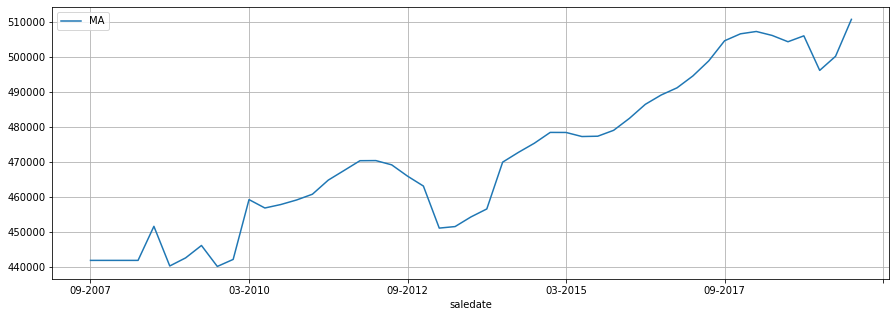

In [ ]:
data1.plot(kind="line",figsize=(15,5), grid = 1)
plt.show()

No seasonality present.
Thus we shall be using the ARIMA model for this data.

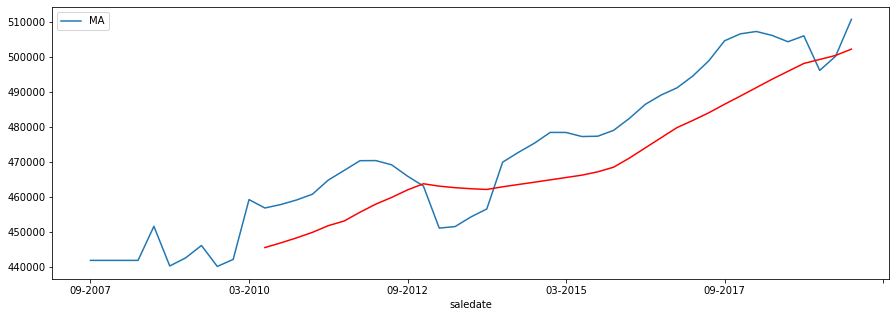

In [ ]:
moving_avg =data1['MA'].rolling(12).mean()
data1.plot(kind="line",figsize=(15,5))
moving_avg.plot(kind="line",figsize=(15,5),color='red')
plt.show()

Rolling averages depict the upward trend.

In [ ]:
# Testing the stationarity of the data using dickey fuller test

from statsmodels.tsa.stattools import adfuller

In [ ]:
test_result = adfuller(data1['MA'])

In [ ]:
#Ho: Data is not stationary
#H1: Data is stationary

def adfuller_test(ma):
    result = adfuller(ma)
    labels = ['ADF Test Statistics', 'P-value', '#Lags Used', 'Number of Observation Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print('Data is stationary')
    else:
        print('Not enough evidence to say that data is stationary')

In [ ]:
adfuller_test(data1['MA'])

ADF Test Statistics : -0.41620726586450985
P-value : 0.9073573726399371
#Lags Used : 1
Number of Observation Used : 47
Not enough evidence to say that data is stationary


In [ ]:
df_difference = data1.copy()
df_difference['seasonal_first_difference'] = df_difference['MA'] - df_difference['MA'].shift(4)
df_difference.head(15)

,MA,seasonal_first_difference
saledate,,
09-2007,441854,NaN
12-2007,441854,NaN
03-2008,441854,NaN
06-2008,441854,NaN
09-2008,451583,9729.0
12-2008,440256,-1598.0
03-2009,442566,712.0
06-2009,446113,4259.0
09-2009,440123,-11460.0


In [ ]:
adfuller_test(df_difference['seasonal_first_difference'].dropna())

ADF Test Statistics : -2.979424042153941
P-value : 0.036861128785506354
#Lags Used : 4
Number of Observation Used : 40
Data is stationary


<AxesSubplot:xlabel='saledate'>

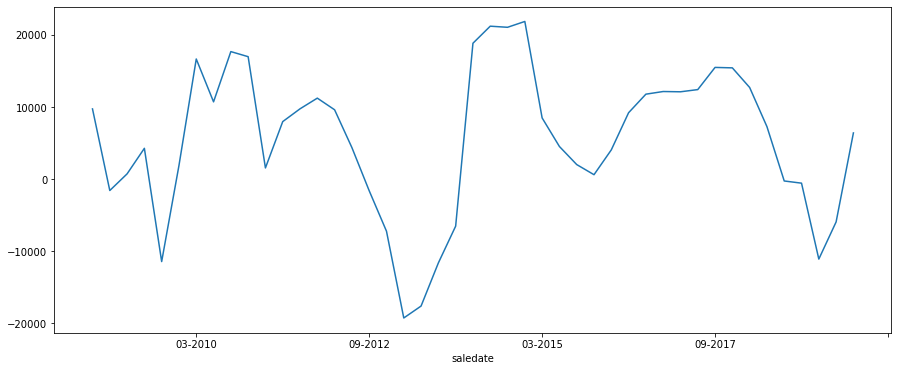

In [ ]:
df_difference['seasonal_first_difference'].plot()

In [ ]:
# selecting the value of p,d,q
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


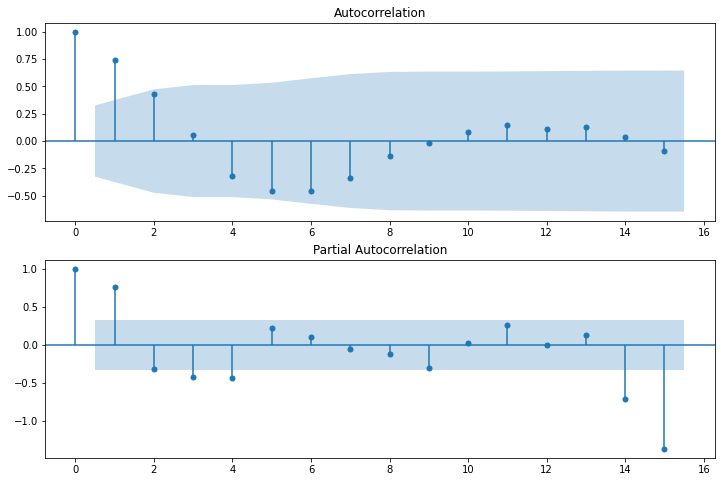

In [ ]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsaplots.plot_acf(df_difference['seasonal_first_difference'].iloc[13:], lags= 15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsaplots.plot_pacf(df_difference['seasonal_first_difference'].iloc[13:], lags= 15, ax=ax2)

p = 2

q = 3

d = 1 (as we did seasonal differecing only once)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model2 = ARIMA(train, order=(2,1,3))
model2_fit=model2.fit(disp=True)
print(model2_fit.summary())

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will

                             ARIMA Model Results                              
Dep. Variable:                   D.MA   No. Observations:                   44
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -431.915
Method:                       css-mle   S.D. of innovations           4227.634
Date:                Thu, 29 Apr 2021   AIC                            877.830
Time:                        10:26:19   BIC                            890.319
Sample:                    12-01-2007   HQIC                           882.461
                         - 09-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1466.7406    850.062      1.725      0.084    -199.350    3132.832
ar.L1.D.MA    -0.1881      0.204     -0.922      0.356      -0.588       0.212
ar.L2.D.MA    -0.6788      0.147     -4.621      0.0

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

 

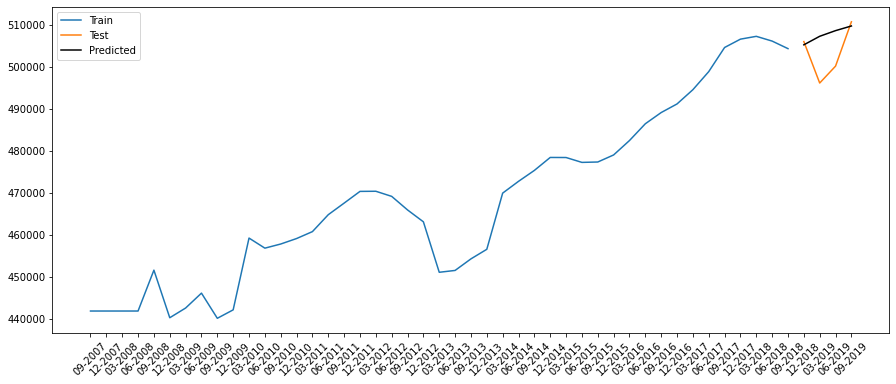

In [ ]:
forecast2 = model2_fit.forecast(steps=4)[0]
forecast2 = pd.DataFrame(forecast2, index = test.index,columns=['Prediction'])
plt.plot(train, label= 'Train')
plt.plot(test, label= 'Test')
plt.xticks(rotation=45)
plt.plot(forecast2, label= 'Prediction', color='black')
plt.legend(['Train', 'Test', 'Predicted'])
plt.show()

In [ ]:
MAE_ARIMA = mean_absolute_error(y_true=test,y_pred=forecast2)
MAE_ARIMA

5336.526670849053

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
ses = SimpleExpSmoothing(train).fit()
ses1 = ses.forecast(4)
ses.summary()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,MA,No. Observations:,45
Model:,SimpleExpSmoothing,SSE,1111872794.530
Optimized:,True,AIC,770.019
Trend:,None,BIC,773.633
Seasonal:,None,AICC,771.019
Seasonal Periods:,None,Date:,"Thu, 29 Apr 2021"
Box-Cox:,False,Time:,10:27:42
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
initial_level,4.4185e+05,l.0,True


In [ ]:
ses1_df = pd.DataFrame(ses1)
ses1_df = ses1_df.reset_index()

In [ ]:
ses1_df = ses1_df.rename(columns={'index':'saledate', 0:'Predicted_MA'} )

In [ ]:
ses1_df

,saledate,Predicted_MA
0,2018-12-01,504327.018215
1,2019-03-01,504327.018215
2,2019-06-01,504327.018215
3,2019-09-01,504327.018215


In [ ]:
ses1_df['saledate'] = ses1_df['saledate'].astype(str)

for i in range(len(ses1_df['saledate'])):
    ses1_df['saledate'].loc[i] = datetime.strftime(datetime.strptime(ses1_df['saledate'].loc[i], '%Y-%m-%d'), '%m-%Y')
ses1_df.set_index('saledate', inplace = True)

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


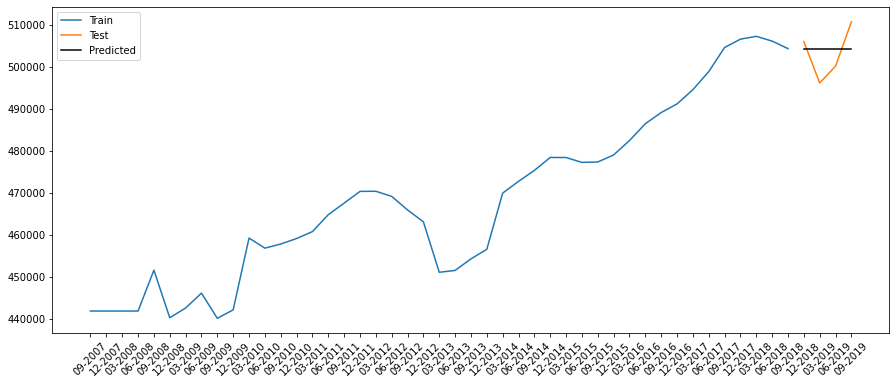

In [ ]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(ses1_df, label='Prediction', color='black')
plt.xticks(rotation=45)
plt.legend(['Train', 'Test', 'Predicted'])
plt.show()

In [ ]:
MAE_SES = mean_absolute_error(y_true=test,y_pred=ses1_df)
MAE_SES

5105.5

In [ ]:
print('ARIMA  --->', MAE_ARIMA)
print('SES    --->', MAE_SES)

ARIMA  ---> 5336.526670849053
SES    ---> 5105.5


SES model is better than the ARIMA model.
Hence, we use it for further prediction.

In [ ]:
ses_model = SimpleExpSmoothing(data1).fit()
results= ses_model.forecast(4)
ses.summary()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,MA,No. Observations:,45
Model:,SimpleExpSmoothing,SSE,1111872794.530
Optimized:,True,AIC,770.019
Trend:,None,BIC,773.633
Seasonal:,None,AICC,771.019
Seasonal Periods:,None,Date:,"Thu, 29 Apr 2021"
Box-Cox:,False,Time:,10:29:25
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
initial_level,4.4185e+05,l.0,True


In [ ]:
ses1_final = pd.DataFrame(results)
ses1_final = ses1_final.reset_index()
ses1_final = ses1_final.rename(columns={'index':'saledate', 0:'Predicted_MA'} )
ses1_final['saledate'] = ses1_final['saledate'].astype(str)

In [ ]:
ses1_final

,saledate,Predicted_MA
0,2019-12-01,510659.130607
1,2020-03-01,510659.130607
2,2020-06-01,510659.130607
3,2020-09-01,510659.130607


In [ ]:
for i in range(len(ses1_final['saledate'])):
    ses1_final['saledate'].loc[i] = datetime.strftime(datetime.strptime(ses1_final['saledate'].loc[i], '%Y-%m-%d'), '%m-%Y')
ses1_final.set_index('saledate', inplace = True)

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


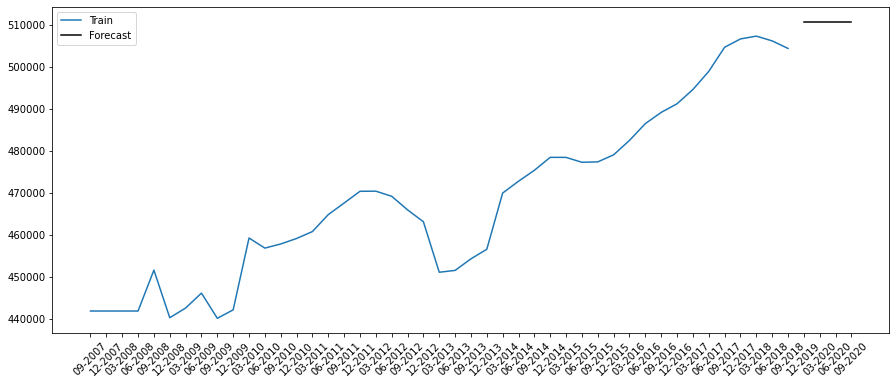

In [ ]:
plt.plot(train, label='Train')
plt.plot(ses1_final, label='Forecast', color='black')
plt.xticks(rotation=45)
plt.legend(['Train',  'Forecast'])
plt.show()